# Trabalho Visão Computacional - Parte 2

- Diego Pavan Soler NUSP: 4607661
- José Luiz Maciel Pimenta NUSP: 11896720
- Luis Ricardo Manrique NUSP: 5779294

# 1 - Introdução

## Compartilhamento do Projeto
- Git: https://github.com/JoseLuiz432/MAC5768.git
- Drive: https://drive.google.com/drive/folders/1bvwXFjPWP-Sdb5Lwh6zFd_vQs24mJ6_c?usp=sharing

# 2 - Objetivos

- Criar um novo dataset chamado de normalizedDataset contendo a equalização de cada classe do augmentedDataSet;

As funções de análise de cada classe abaixo devem ser aplicadas ao originalGrayDataset, augmentedDataset e normalizedDataset.
- Mostrar o protótipo médio de cada classe;
- Histograma médio de cada classe
- Variância do histograma de cada classe


##2.1 - Ambiente de Trabalho

Este notebook foi desenvolvido no Google Colab. Assim, aproveitamos o fato de poder acessar o Google Drive diretamente. Contudo, para que isso seja possível é necessário ter acesso a pasta "Trabalho_Visão" (Link do Drive em 1), criar um atalho, desta pasta, no diretorio raiz do Drive ("/content/gdrive/My_Drive") e, por fim, executar o código abaixo para que o Colab tenha acesso ao seu Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Após uma motagem do Drive ser bem sucedida, é necessário mudar o diretório de trabalho para a pasta "Trabalho_Visão". Isso é feito executando a celula abaixo:

In [ ]:
import os
os.chdir('/content/gdrive/My Drive/Trabalho_Visao')

Importar as funções necessárias.

In [ ]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray
import pandas as pd

Carregar os metadados das imagens utilizadas

In [ ]:
df = pd.read_csv('dataset/dataset.csv')
df_gray = pd.read_csv('dataset/gray_dataset.csv')

# 3 - Desenvolvimento

Nesta secção será realizado a normalização das imagens de cada classe do augmentedDataSet.

Será utilizado a equalização de histogramas como função inicial de normalização, gerando o dataset: **“normalizedDataset”**. 

Em seguida, cada uma das funções de análise listas abaixo, serão aplicadas aos três datasets gerados, **“originalGrayDataset”**, **“augmentedDataset”** e **“normalizedDataset”**.

1. Protótipo médio de cada classe
2. Histograma médio de cada classe
3. Variância do histograma de cada classe


## 3.1 - Equalização de Histograma 

$s_k = \frac{(L - 1)}{MN} \sum_{j=0}^k n_j$    (3.1)

 Em que: \\
 $0 \leq k \leq (L - 1)$ \\
 $M$ é o número de linhas da imagem. \\
 $N$ é o número de colunas da imagem. \\
 $n_j$ é a quantidade de pixels de intensidade j \\

In [ ]:
def soma_pixel(imagem, valor, tabela):
  """ 
  Realiza a somatoria da equação 3.1. 
  Em que:
    imagem -- é uma matriz M por N
    valor  -- é o valor de k
    tabela -- são os valores, para k, já calculados

  Utilizando uma tabela de valores já calculado
  """
  try:
    return tabela[valor]
  except:
    if valor == 0:
      tabela[valor] = len(imagem[imagem == 0])
      return tabela[valor]
    else:
      tabela[valor] = len(imagem[imagem == valor]) + soma_pixel(imagem, valor-1, tabela)
      return tabela[valor]

In [ ]:
def equaliza(imagem):
  """
  Realiza a equalização sobre a imagem
  
  equaliza(np.array) -> np.array
  """
  tabela = {}
  l, c = imagem.shape
  new_image = np.zeros((l, c))
  # L - 1 = 256 - 1 = 255
  aux = 255/(l*c)
  # calcular o novo valor para cada pixel da imagem
  for i in range(l):
    for j in range(c):
      new_image[i,j] = aux * soma_pixel(imagem, imagem[i,j], tabela)

  return new_image

In [ ]:
pastas = ['gradient'] # 'exp', 'log', 'mean', 'gradient'
aux_pasta = 'dataset/%s_dataset.csv'
save_path = 'dataset/augmentation/normalizedDataset/%s/%s'
read_path = 'dataset/'

new_df = "DIR\tDATE\tCLASS_NAME\tOBJ_ID\tBACKGROUND\tLIGHT\tINDOOR\n"
for pasta in pastas:

  df_aux = pd.read_csv((aux_pasta % pasta))

  for row in df_aux.iterrows():
    row = row[1]
    fname = row['DIR']
    fname = fname.split('/')
    fname = '/'.join(fname[-2:])
    fname_save = save_path % (pasta, fname)

    img = 'dataset/' + row['DIR']    
    img = io.imread(img)

    
    nw_img = equaliza(img)
    nw_img = nw_img.astype(np.uint8)
    print(fname_save)
    io.imsave(fname_save, nw_img)

    fname_df = 'augmentation/normalizedDataset/%s/%s' % (pasta, fname)
    new_df += "%s\t%s\t%s\t%s\t%s\t%s\t%s\n" %(
        fname_df, "15-11-2020", row['CLASS_NAME'], 
        row['OBJ_ID'], row['BACKGROUND'],
        row['LIGHT'],row['INDOOR']) 

    
arquivo = open('dataset/normalizedDataset.csv', 'w')
arquivo.write(new_df)
arquivo.close()

### Exemplo Equalização

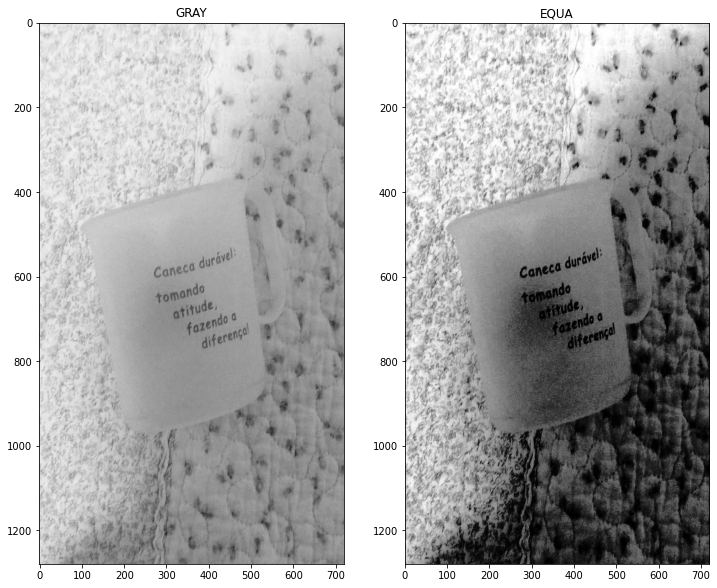

In [ ]:
df_equa = pd.read_csv('dataset/normalizedDataset.csv')
img_equa = io.imread('dataset/augmentation/normalizedDataset/gray/Caneca/Caneca-137.jpg')
img_gray = io.imread('dataset/augmentation/originalGrayDataset/Caneca/Caneca-137.jpg')
fig, axarr = plt.subplots(1,2, figsize=(12, 12))
axarr[0].set_title('GRAY')
axarr[1].set_title('EQUA')
axarr[0].imshow(img_gray, cmap='gray')
axarr[1].imshow(img_equa, cmap='gray')

## 3.2 - Protótipo médio de cada classe

A seguir será calculado o protótipo médio de cada classe para as imagens do dataset original em escala de cinza e cada um dos dataset expandidos (grad, exp, log, mean). 

Para se obter uma boa qualidade do protótipo médio é preciso tomar cuidado capturar as imagens com bastante cuidado e padronização, uma forma de se obter esta padronização é utilizando um tripé de suporte para a câmera, capturar a imagem por meio de trigger, iluminação artificial e garantindo que os objetos estejam no mesmo local.

Como não foi feito na totalidade estes cuidado, espera-se que apenas a forma básica de cada classe seja mantido.


In [ ]:
# Recolher nome das classes
unique_class = list(set(df['CLASS_NAME'].to_list()))
original = 'dataset/augmentation/originalGrayDataset/%s/'
augmented = 'dataset/augmentation/augmentedDataset/%s/%s/'
normalized = 'dataset/augmentation/normalizedDataset/%s/%s/'

print(unique_class)

# Iniciar
classimgmean = {}

X = np.zeros((1280,720))
i = 0
img_plot = []

for classname in unique_class: # Para cada classe
  X = np.zeros((1280,720))
  i = 0
  file_list = os.listdir(original % classname)
  for fname in file_list: # Em cada imagem nesta classe
    img = np.array(mpimg.imread(original % classname + fname))

    # Soma das imagens
    X = X + img
    i = i + 1

    # print(np.max(X)/i) # Utilizado para verificar se não esta saturando
 
  # Calculo da media
  X = X / i
  fname = 'dataset/augmentation/Prototipo medio de cada classe/%s/original_%s.jpg'%(classname,classname)
  img_plot.append(X)
  io.imsave(fname, X.astype(np.uint8))

classimgmean['original'] = img_plot

for dset in ['exp', 'gradient', 'log', 'mean']:
  img_plot = []
  for classname in unique_class: # Para cada classe
    print('%s %s'%(dset,classname))
    X = np.zeros((1280,720))
    i = 0
    file_list = os.listdir(augmented % (dset, classname))
    for fname in file_list: # Em cada imagem nesta classe
      img = np.asarray(mpimg.imread(augmented % (dset, classname) + fname))

      # Soma das imagens
      X = X + img
      i = i + 1

    # Calculo da media
    X = X / i
    fname = 'dataset/augmentation/Prototipo medio de cada classe/%s/%s_%s.jpg'%(classname,dset,classname)
    img_plot.append(X)
    io.imsave(fname, X.astype(np.uint8))

  classimgmean[dset] = img_plot

for dset in ['exp', 'gradient', 'log', 'mean']:
  img_plot = []
  for classname in unique_class: # Para cada classe
    print('%s %s'%(dset,classname))
    X = np.zeros((1280,720))
    i = 0
    file_list = os.listdir(normalized % (dset, classname))
    for fname in file_list: # Em cada imagem nesta classe
      img = np.asarray(mpimg.imread(normalized % (dset, classname) + fname))

      # Soma das imagens
      X = X + img
      i = i + 1

    # Calculo da media
    X = X / i
    fname = 'dataset/augmentation/Prototipo medio de cada classe/%s/Normalized_%s_%s.jpg'%(classname,dset,classname)
    img_plot.append(X)
    io.imsave(fname, X.astype(np.uint8))

  classimgmean['Norm_' + dset] = img_plot

In [ ]:
dset = ['original','gradient', 'Norm_gradient', 'exp', 'Norm_exp', 'log', 'Norm_log', 'mean', 'Norm_mean']
for d in dset:
  f, axs = plt.subplots(1,10)
  f.set_size_inches(25, 25)

  for i, pmimg in enumerate(classimgmean[d]):
    axs[i].imshow(pmimg, cmap='gray')
    axs[i].axis('off')
    title = '%s_%s'%(d,unique_class[i])
    axs[i].set_title(title)
  plt.show()
  

Output hidden; open in https://colab.research.google.com to view.

Analisando as imagens, pode-se notar alguns pontos. Mesmo que não foram tomados todos os cuidados para capturar as imagens, percebe-se que alguns protótipos médicos ficaram de ótima qualidade, destacando-se, **Caneca**, **Faca** e **Perfume**, sendo que no último, é possível distinguir o logo da marca. Outra observação, é que as alterações feitas no para gerar o dataset aumentado, está bem visível nos protótipos, especialmente em alterações constantes, como o gradiente e o filtro da média.

## 3.3 - Histograma médio de cada classe

Para o cálculo do histograma foi utilizada a função **numpy.histogram**, que recebe uma matriz e retorna dois vetores, um com os valores em Y da frequência absoluta, e outro em X com os intervalos dos **bins**. Com os valores de frequência absoluta somados, calculamos a média dividindo pelo número total de imagens de cada classe.

Optou-se por gerar histogramas com 256 **bins**, dessa forma é possível verificar o valor médio para cada intensidade de cinza dos 8 bits.

As 3 colunas representam os seguintes datasets:

* originalGrayDataset;
  - Histograma médio de todas as imagens de cada classe em GrayScale;
* augmentedDataset;
  - Histograma médio de todas as imagens de cada classe aplicados os filtros **log, exp, gradient e mean**;
* normalizedDataset;
  - Histograma médio de todas as imagens de cada classe aplicados os filtros **log, exp, gradient, gray e mean**;

As linhas representam cada uma das categorias de objetos: Calcado, Caneca, Caneta, Controle, Faca, Livro, Mouse, Pendrive, Perfume e Rolha.


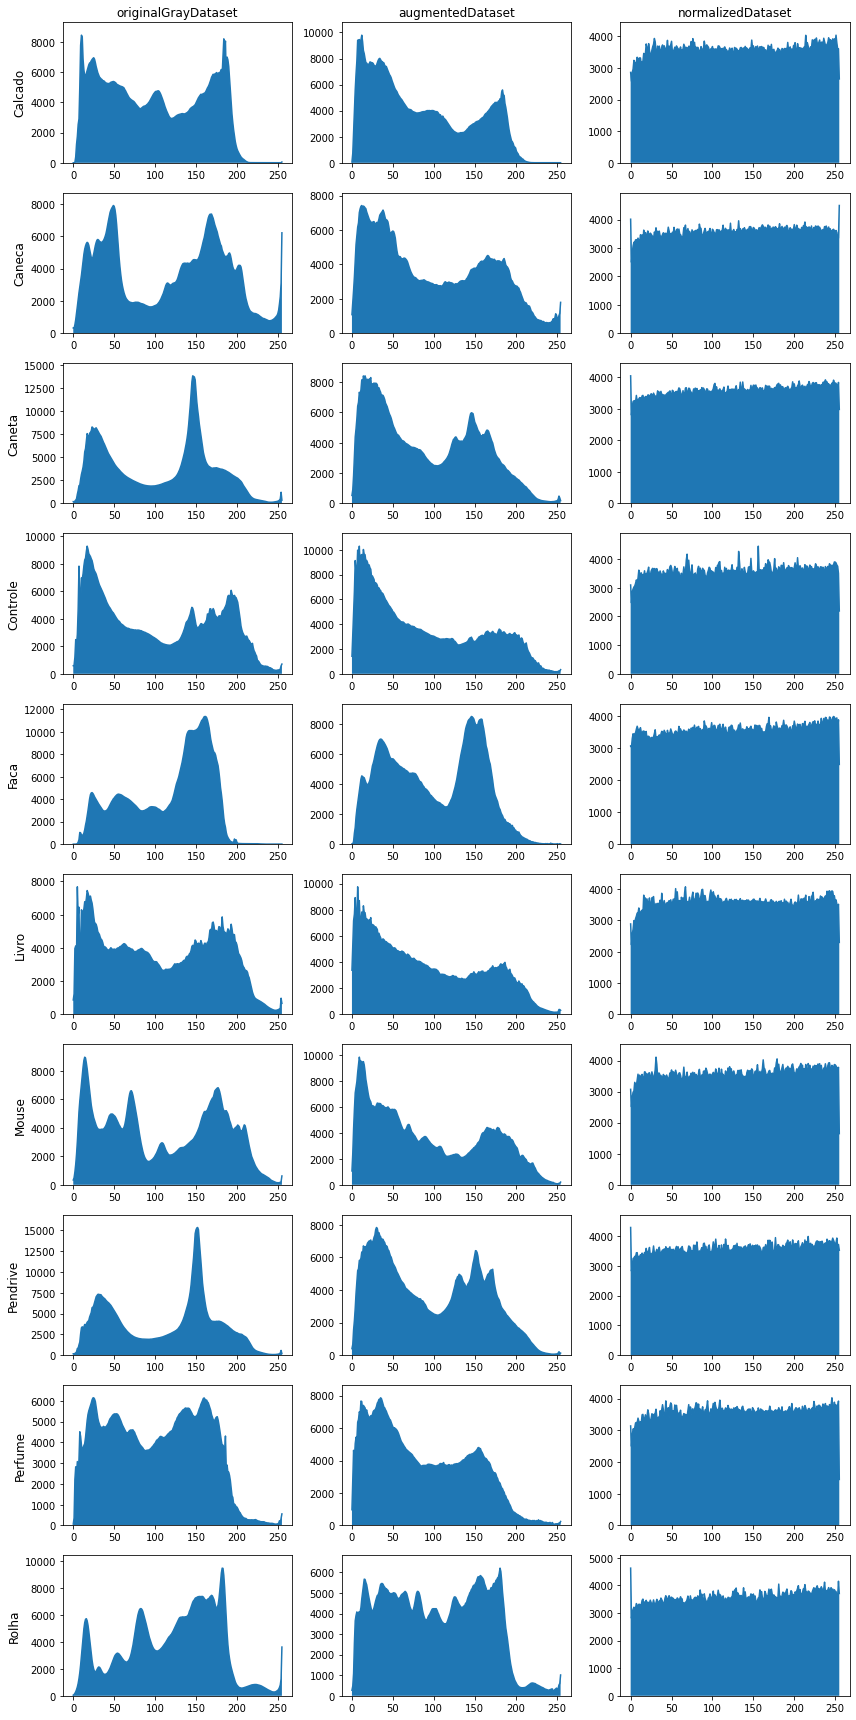

In [ ]:
original = "dataset/augmentation/originalGrayDataset/"
augmented = "dataset/augmentation/augmentedDataset/"
normalized = "dataset/augmentation/normalizedDataset/"
cols = ['originalGrayDataset', 'augmentedDataset', 'normalizedDataset']
rows = sorted(os.listdir(original))
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(12, 24))

for idx, dir in enumerate(sorted(os.listdir(original))):
  hist = np.zeros(256)
  bins = np.zeros(256)
  for image in os.listdir(original + dir):
    img = io.imread(original + dir + '/' + image)
    tmp_hist,bins = np.histogram(img.ravel(),256,[0,256])
    hist = hist + tmp_hist
  hist = hist / len(os.listdir(original + dir))
  axes[idx][0].plot(bins[:-1], hist)
  axes[idx][0].set_ylim(0,np.max(hist) * 1.1)
  axes[idx][0].fill_between(bins[:-1], hist, 0)

  hist = np.zeros(256)
  bins = np.zeros(256)
  divisor = 0
  for filter in os.listdir(augmented):
    divisor += len(os.listdir(augmented + filter + '/' + dir))
    for image in os.listdir(augmented + filter + '/' + dir):
      img = io.imread(augmented + filter + '/' + dir + '/' + image)
      tmp_hist,bins = np.histogram(img.ravel(),256,[0,256])
      hist = hist + tmp_hist
  hist = hist / divisor
  axes[idx][1].plot(bins[:-1], hist)
  axes[idx][1].set_ylim(0,np.max(hist) * 1.1)
  axes[idx][1].fill_between(bins[:-1], hist, 0)

  hist = np.zeros(256)
  bins = np.zeros(256)
  divisor = 0
  for filter in os.listdir(normalized):
    divisor += len(os.listdir(normalized + filter + '/' + dir))
    for image in os.listdir(normalized + filter + '/' + dir):
      img = io.imread(normalized + filter + '/' + dir + '/' + image)
      tmp_hist,bins = np.histogram(img.ravel(),256,[0,256])
      hist = hist + tmp_hist
  hist = hist / divisor
  axes[idx][2].plot(bins[:-1], hist)
  axes[idx][2].set_ylim(0,np.max(hist) * 1.1)
  axes[idx][2].fill_between(bins[:-1], hist, 0)

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

fig.tight_layout()
plt.savefig('histogram_full.png')
plt.show()

Através do histograma médio da coluna "originalGrayDataset" é possível identificar picos, que significam uma grande quantidade de pixels com tons de cinza próximos, alguns têm frequência acima de 12.000. Esses picos nas extremidades podem indicar que algumas imagens têm uma concentração de tons claros ou escuros, o que parece ser o caso, pois o nosso conjunto de imagens original possui fotos com iluminação variável e fundos claros e escuros.

Na coluna -- é possível identificar uma atenuação dos picos verificados no originalGrayDataset, nesse conjunto de imagens a concentração em torno de um mesmo valor não passa de 10.000. Há também um aumento na frequência dos valores no intervalo [0,50], o que indica o escurecimento das imagens, isso pode ser um reflexo da inserção das imagens com os filtros gradiente e exp. 

Os histogramas da coluna "normalizedDataset" mostram uma distribuição mais uniforme da frequência absoluta, eliminando os picos citados nos dois outros datasets. Isso inidica que há uma quantidade similar de pixels em toda a escala de intensidades de cinza, isso pode atenuar o brilho em imagens muito claras ou escuras.

## 3.4 Variância e Desvio Padrão dos Histogramas


Para o cálculo da variância foi utilizada a função **numpy.var**, que recebe um conjunto de vetores com valores da frequência absoluta (histogramas) e retorna um vetor com os valores médios dos desvios ao quadrado em relação à média de cada ponto.

Após análise da variância, optou-se por utilizar a raiz quadrada desses valores (**numpy.std**), dessa forma é possível visualizar em um único plot o histograma médio e, em cada bin, uma barra em Y com o valor do desvio padrão. Quando utilizados os valores da variância nos plots, perde-se a visualização da variação de valores do histograma médio, isso se dá pela grande diferença entre os valores da variância e dos pontos médios.

Foram utilizados histogramas com 64 **bins** para facilitar a visualização das barras com o desvio padrão.

As 3 colunas representam os seguintes datasets:

* originalGrayDataset;
  - Histograma médio de todas as imagens de cada classe em GrayScale e o desvio padrão em uma barra vertical em cada ponto;
* augmentedDataset;
  - Histograma médio de todas as imagens de cada classe aplicados os filtros **log, exp, gradient e mean** e o desvio padrão em uma barra vertical em cada ponto;
* normalizedDataset;
  - Histograma médio de todas as imagens de cada classe aplicados os filtros **log, exp, gradient, gray e mean** e o desvio padrão em uma barra vertical em cada ponto;

As linhas representam cada uma das categorias de objetos: Calcado, Caneca, Caneta, Controle, Faca, Livro, Mouse, Pendrive, Perfume e Rolha.

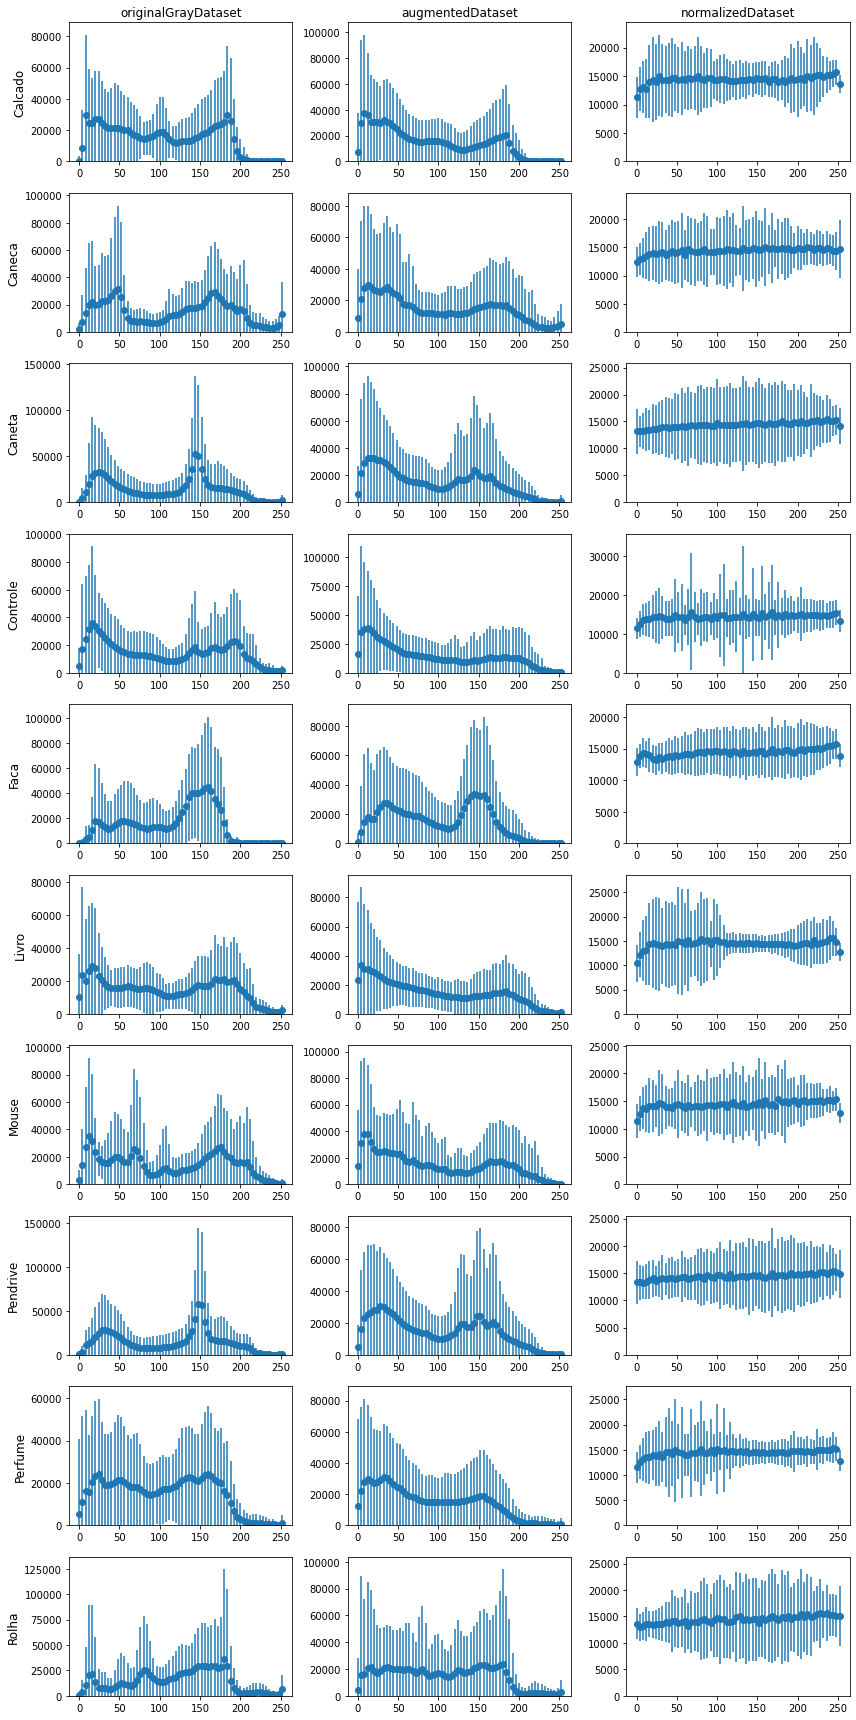

In [ ]:
original = "dataset/augmentation/originalGrayDataset/"
augmented = "dataset/augmentation/augmentedDataset/"
normalized = "dataset/augmentation/normalizedDataset/"
cols = ['originalGrayDataset', 'augmentedDataset', 'normalizedDataset']
rows = sorted(os.listdir(original))

fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(12, 24))
for idx, dir in enumerate(sorted(os.listdir(original))):
  hist = []
  bins = np.zeros(64)
  for image in os.listdir(original + dir):
    img = io.imread(original + dir + '/' + image)
    tmp_hist,bins = np.histogram(img.ravel(),64,[0,256])
    hist.append(tmp_hist)
  hist_mean = np.asarray(hist).mean(axis=0)
  hist_var = np.asarray(hist).std(axis=0)
  axes[idx][0].errorbar(bins[:-1], hist_mean, yerr=hist_var, fmt="o")
  axes[idx][0].set_ylim(0,np.max(hist_mean + hist_var) * 1.1)
  
  hist = []
  bins = np.zeros(64)
  for filter in os.listdir(augmented):
    for image in os.listdir(augmented + filter + '/' + dir):
      img = io.imread(augmented + filter + '/' + dir + '/' + image)
      tmp_hist,bins = np.histogram(img.ravel(),64,[0,256])
      hist.append(tmp_hist)
  hist_mean = np.asarray(hist).mean(axis=0)
  hist_var = np.asarray(hist).std(axis=0)
  axes[idx][1].errorbar(bins[:-1], hist_mean, yerr=hist_var, fmt="o")
  axes[idx][1].set_ylim(0,np.max(hist_mean + hist_var) * 1.1)

  hist = []
  bins = np.zeros(64)
  for filter in os.listdir(normalized):
    for image in os.listdir(normalized + filter + '/' + dir):
      img = io.imread(normalized + filter + '/' + dir + '/' + image)
      tmp_hist,bins = np.histogram(img.ravel(),64,[0,256])
      hist.append(tmp_hist)
  hist_mean = np.asarray(hist).mean(axis=0)
  hist_var = np.asarray(hist).std(axis=0)
  axes[idx][2].errorbar(bins[:-1], hist_mean, yerr=hist_var, fmt="o")
  axes[idx][2].set_ylim(0,np.max(hist_mean + hist_var) * 1.1)

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

fig.tight_layout()
plt.savefig('histogram_variancia.png')
plt.show()

Observa-se nas colunas "originalGrayDataset" e "augmentedDataset" picos nas regiões [0,50] e [150,200], indicando uma grande variação no número de pixels nessas regiões nas diferentes imagens. Apesar desse comportamento aparecer nas duas colunas, nota-se uma variação menor no "augmentedDataset" quando se observa a escala em Y.

Na coluna "normalizedDataset" não se observa picos em regiões específicas, há uma distribuição mais uniforme e em escala muito menor em relação aos outros datasets. 